# Recomendador para series de anime
__Emilio Lizama, Alonso Reyes, Juan-Pablo Silva__

## 1. Introducción

En la última década, la cultura japonesa ha a comenzado a despertar un interes creciente en occidente. Cada vez más gente está interesada en visitar Japón, leer su literatura, y como no, ver sus series de televisión animadas: anime.
El anime es un término usado para referirse a la animación japonesa, la cual puede tener tematicas infantiles, acción o temas más complejos, dirigidos a audiencias adultas.

Aun así con todo este aumento de personas interesadas y viendo anime, no existe alguna página web o aplicación que analice gustos y trate de recomendar series que probablemente serán de agrado de quien las buscó. Actualmente las páginas más populares para llevar registro de qué anime se han visto solo recomiendan anime de forma general por sus puntuaciones totales, o los clásicos "porque viste A te podría gustar B", cosas que son calculos básicos hechos acorde a los distintos géneros de cada serie y si coinciden con otras, de preferencia de mayor puntuación. Es por esto que nosotros en el proyecto crearemos un sistema recomendador, que actúe como un predictor sobre si a cierto usuario le gustará o no cierto anime, y podrá generar recomendaciones personalizadas entorno a registros sobre cada usuario.

## 2. Datos

Los datos fueron obtenidos desde __[MyAnimeList](https://myanimelist.net/)__, una página que contiene una base de datos sobre todos los anime, junto a sus géneros, y puntajes promedios otorgados por usuarios. El principal propósito de esta página, es que sus usuarios sean capaces de guardar en sus "listas" los anime que han visto y que les asignen un puntaje del 1 al 10. De esta forma se van modificando los puntajes promedio sobre los anime.

### 2.1 Obtención de datos

Para obtener estos datos implementamos un programa que recolecta información a través del código HTML de las páginas disponibles en MyAnimeList, es decir, un scraper. Es importante confirmar que seguimos estrictamente las indicaciones fijadas por el archivo "robots.txt" y los terminos de servicio de MyAnimeList y no violamos ninguna ley en el proceso... mientras no distribuyamos ni usemos comercialmente los datos recolectados.

El generar nosotros mismos los datos nos da acceso a decidir nosotros en qué formato, de qué manera y cómo queremos los datos, esto será explicado a continuación.

### 2.2 Descripción de los datos

Al usar el scraper, recolectamos los datos en 2 archivos: __anime__ y __users__. El archivo __anime__ contiene información acerca de géneros, puntuaciones, nombres, entre otros mucho valores recolectados sobre todos los anime de la base de datos de MyAnimeList, esto es alrededor de 13.500 filas, lo que se reduce a 13.500 anime. El archivo __users__ contiene información sobre todos los anime que han visto, estan viendo y quieren ver de 4.200 usuarios aproximadamente. Ésto, un anime por fila por cada uno de los 4.200 usuarios, significa en alrededor de 1 millón 500 mil filas. Es necesario decir que 4.200 no es ni cercanamente el total de usuarios presentes en el sitio, considerando que en todo momento se encuentran más de 8.000 usuarios online y el anime que registra más vistas contiene mas de 1 millón 200 mil, lo que significa que en el sitio existen al menos esa cantidad de usuarios. Dicho esto, la obtención de listas de usuarios al hacerse de acuerdo a los términos de servicio de MyAnimeList tomó un poco mas de 18 horas para los 4.200 usuarios, por lo que se estimó que usaremos esa cantidad para pruebas preliminares y exploración de los datos del proyecto.

Estos archivos contienen mucha información y en un formato no amigable con parsers para gráficos, ni bases de datos, por lo que reformateamos los datos en 4 archivos: __date__, __genre__, __general__ y __mal_filled__, cada uno de estos archivos representa una tabla en una base de datos. Los contenidos de los archivos son como sigue:

- __general__: contiene información acerca del nombre, puntaje, favoritos, cantidad de episodios, fuentes de adaptación, formato de difusión, entre otras variables de cada anime en MyAnimeList.
- __date__: almacena las fechas de inicio y término de cada anime en el archivo __general__.
- __genre__: contiene cada género de cada anime listado en el archivo __general__
- __mal_filled__: contiene todos los anime de cada lista de usuario recolectada, junto a al puntaje otorgado, e información acerca si el usuario ya terminó de ver la serie o no.

El archivo __mal_filled__ está filtrado de tal manera que no contiene anime "plan to watch" ni "watching" de las listas de usuarios, ya que no consideramos que fueran útiles para representarlos gráficamente, aunque planeamos hacer uso de ellos en el modelo final. También, muchos datos sobre las listas de usuarios no tenian puntajes asignados a ciertos anime, por ello decidimos asignarle a cada uno el puntaje promedio total que calculamos. Además de esto, existen los anime en estado "dropped", es decir que el usuario dejó de verlo sin terminar, a estos anime rellenamos los valores incompletos con un puntaje de 3.

### 2.3 Exploración de los datos

Con los datos formateados y divididos en tablas que pueden ser usadas para graficos y tablas SQL hicimos algunos graficos para visualizar el general de datos que tenemos.

Antes que nada, importamos los módulos necesarios para visualizar.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib notebook

Luego cargamos los archivos que contienen los datos que mostraremos:

In [2]:
genre_data = pd.read_csv("genre.csv")
anime_data = pd.read_csv("general.csv")
user_data = pd.read_csv("mal_filled.csv")

Este es un merge de archivos especialmente lento, por lo que lo hacemos independientemente de los graficos.

In [3]:
user_genre = pd.merge(genre_data, user_data, on='anime_id')

A continuación presentamos una estadística de géneros más vistos por intervalos de cantidad total de anime completados por el usuario. Esto es, cuáles son los géneros de anime más vistos dentro de usuarios que han visto cierta cantidad de anime.

In [4]:
# Esto es particularmente lento
completed_data = user_genre[user_genre['anime_status'] == 'completed']
cnt = completed_data.groupby(['username'], as_index=False).agg({'anime_name': np.size}) # Cuantos ha visto cada usuario
cnt.columns.values[1] = 'count'
cnt_data = pd.merge(completed_data, cnt, on='username') #

In [5]:
intervals = []
genres = []
interval_size = 100
for i in range(20):
    c = cnt_data[(cnt_data['count'] > i*interval_size) & (cnt_data['count'] <= (i+1)*interval_size)]
    gb = c.groupby(['genre'], as_index=False).agg({'anime_name': np.size})
    gb.columns.values[1] = 'count'
    intervals.append("{}-{}".format((i*interval_size)+1, (i+1)*interval_size))
    top_three = [row['genre'] for index, row in gb.nlargest(5, ['count']).iterrows()]
    genres.append(top_three)

data = {'Genres': genres, 'Interval': intervals}
interval_df = pd.DataFrame(data)
cols = interval_df.columns.tolist()
cols = cols[-1:] + cols[:1]
interval_df = interval_df[cols]
interval_df

,Interval,Genres
0,1-100,"[Action, Comedy, Drama, Fantasy, Supernatural]"
1,101-200,"[Comedy, Action, Supernatural, Drama, Fantasy]"
2,201-300,"[Action, Comedy, Supernatural, School, Fantasy]"
3,301-400,"[Comedy, Action, School, Supernatural, Drama]"
4,401-500,"[Comedy, Action, School, Supernatural, Romance]"
5,501-600,"[Comedy, Action, School, Romance, Fantasy]"
6,601-700,"[Comedy, Action, Romance, School, Fantasy]"
7,701-800,"[Comedy, Action, Romance, School, Fantasy]"
8,801-900,"[Comedy, Action, Romance, School, Fantasy]"
9,901-1000,"[Comedy, Action, Romance, School, Fantasy]"


Como podemos ver, hay muy poca variación entre los géneros más vistos entre los distintos rangos de anime vistos. Si bien esto se sale un poco de lo que esperabamos, ya que esperabamos ver un poco más de variación entre los usuarios con más anime vistos, es relativamente esperable, ya que sacamos un pequeño porcentaje de listas de usuarios de MyAnimeList. Ahora bien, la gran mayoría de rangos de usuarios tiene a "Comedia" como el género más visto, pero quizas esto pueda ser explicado por como se distribuyen los géneros de anime entre el total de anime que existen.

A continuación se presenta una estadística que muestra el total de anime con cierto género visto por cada usuario, versus el total de anime con ese género.

In [6]:
#User count
total_user_genre = user_genre.groupby(by=['genre']).agg({'genre':np.size})

total_user_genre.sort_values(by='genre', ascending=False, inplace=True)
total_user_genre.rename(columns={'genre':'Total Count User'}, inplace=True)
total_user_genre.reset_index(inplace=True)
total_user_genre.rename(columns={'genre':'Genres'}, inplace=True)

#Total anime count
total_genre = genre_data.groupby(by=['genre']).agg({'genre':np.size})

total_genre.sort_values(by='genre', ascending=False, inplace=True)
total_genre.rename(columns={'genre':'Total Count Anime'}, inplace=True)
total_genre.reset_index(inplace=True)
total_genre.rename(columns={'genre':'Genres'}, inplace=True)

#Slow merge I guess
genre_user_anime_total = pd.merge(total_user_genre, total_genre, on='Genres')

genre_user_anime_total['Proportion'] = genre_user_anime_total['Total Count User']/genre_user_anime_total['Total Count Anime']

genre_user_anime_total.sort_values(by='Proportion', ascending=False, inplace=True)

genre_user_anime_total

,Genres,Total Count User,Total Count Anime,Proportion
23,Thriller,36987,107,345.672897
14,Harem,88805,333,266.681682
17,Psychological,63258,248,255.072581
30,Vampire,22883,106,215.877358
5,Supernatural,225882,1144,197.449301
3,School,253480,1340,189.164179
13,Mystery,97533,536,181.964552
2,Romance,264798,1567,168.984046
12,Seinen,101729,603,168.704809
11,Ecchi,114474,680,168.344118


Como podemos ver, si bien comedia es el género más visto, también es el más abundante, por lo que al sacar una proporción simple entre cuantos se han visto versus cuantos hay, se obtiene que el más visto relativo a cuantos hay es el género de "Suspenso".

Como una explicación más visual de cómo se distribuyen los géneros vistos en las listas de los usuarios generamos el siguiente gráfico de torta.

<IPython.core.display.Javascript object>


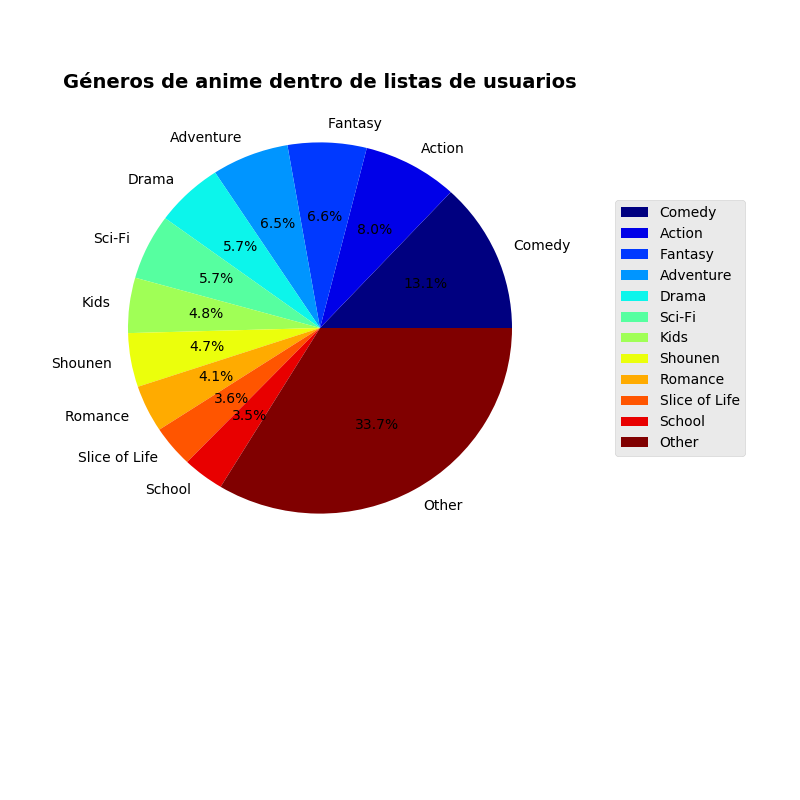

In [7]:
genres_counts = genre_data['genre'].value_counts() 
Otros = pd.DataFrame([genres_counts[12:].sum()], ["Other"])
genres_counts2 = genres_counts[:11].append(Otros)
genre_plot = pd.DataFrame(genres_counts2)

#pie = genre_plot.plot.pie(subplots=True, figsize=(6, 6),autopct='%1.1f%%')
pie = genre_plot.plot.pie(subplots=True, figsize=(8, 8),autopct='%1.1f%%',cmap='jet')

plt.title('Géneros de anime dentro de listas de usuarios', weight='bold', size=14)
plt.legend(bbox_to_anchor=(1.4,0.5), loc="center right", fontsize=10)
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.7)
plt.ylabel('')
plt.show()

Así sabemos cómo se distribuyen los géneros en el total de anime y de anime vistos por cada usuario. Es importante recalcal nuevamente que poseemos solo un pequeño universo de datos de listas de usuarios, por lo que los resultados pueden variar cuando obtengamos más. Sin embargo, estimamos que las proporciones se mantengan casi estables por la distribución total de anime que hay, si hay más de X, es normal que se vea más X.

Ahora queremos saber como se distribuyen los puntajes de dados por cada usuario a los distintos anime, para ello hicimos la siguiente estadística.

In [8]:
av_genre = user_genre.groupby(as_index=False, by=['genre']).agg({'user_score':np.mean})
av_genre.sort_values(by='user_score', ascending=False, inplace=True)
av_genre.rename(columns={'genre':'Genres', 'user_score':'Average user score'}, inplace=True)
av_genre.reset_index(drop=True, inplace=True)

av_genre

,Genres,Average user score
0,Thriller,7.709628
1,Samurai,7.433748
2,Psychological,7.388204
3,Police,7.345594
4,Drama,7.339983
5,Military,7.311072
6,Mystery,7.310141
7,Supernatural,7.273771
8,Historical,7.262771
9,Shounen,7.254452


Podemos ver que nuevamente aparece "Suspenso" como primero en la lista, en este caso aparece como el género con mejor puntuación promedio. Esto nos da una idea de cómo se encuentra distribuida el rango total de puntajes hechos por los usuarios. Para obtener la distribucion real de esto usamos el siguiente código.

<IPython.core.display.Javascript object>


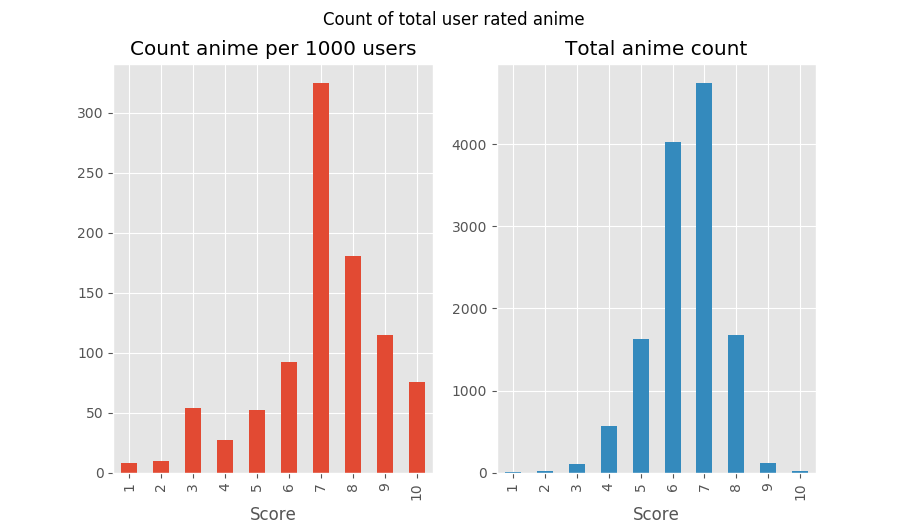

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA35198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BDBD748>]], dtype=object)

In [9]:
def scale_user_score(scores):
    return np.size(scores) / 1000

anime_average_score = user_data.groupby(by=['user_score']).agg({'user_score':scale_user_score})
anime_average_score.rename(columns={'user_score':'Count anime per 1000 users'}, inplace=True)
anime_average_score.reset_index(inplace=True)
anime_average_score.rename(columns={'user_score':'Score'}, inplace=True)

anime_temp_score = anime_data
anime_temp_score['int_score'] = anime_temp_score['score'].apply(np.round)
anime_total_score = anime_temp_score.groupby(by=['int_score']).agg({'int_score':np.size})
anime_total_score.rename(columns={'int_score':'Total anime count'}, inplace=True)
anime_total_score.reset_index(inplace=True)
anime_total_score.rename(columns={'int_score':'Score'}, inplace=True)


final_score = pd.merge(anime_average_score, anime_total_score, on='Score')

final_score


final_score.plot(kind='bar', x='Score', legend=False, title="Count of total user rated anime", subplots=True, layout=(1,2))

En el grafico anterior se muestran 2 graficos de barras, ambos representan como se distribuyen las puntuaciones de anime, pero sobre distintos objetos. En el primer gráfico se muestra como estan puntuados los anime en las listas de usuarios, como podemos ver, la gran mayoria de los anime fueron catalogados como 7.
En el caso del segundo gráfico, éste representa la distribución de los puntajes promedio totales entre todos los usuarios de MyAnimeList. Este puntaje esta incluido por cada anime que recolectamos. Como podemos ver, los puntajes de los usuarios que recolectamos se podrían considerar "inflados".
Se puede ver una irregularidad en el primer gráfico para el puntaje "3". Esto es porque nosotros manualmente rellenamos los anime en estado "dropped" que no tuvieran puntuacion con una clasificación de 3.

***

## 3. Problema

El problema entonces que queremos resolver es el analizar gustos y recomendar anime entorno a ellos.

### 3.1 Descripción

El proyecto principalmente consiste en buscar una manera de modelar el problema e intentar que algun modelo aprenda sobre los gustos de ciertos usuarios y luego sea capaz de recomendarles anime en base a lo que han visto. De esta manera se tendra un sistema que sea capaz de clasificar un alto número de variables, considerando todos los elementos en las listas de los usuarios, esto es anime "completados", "por ver" y "dropped".

### 3.2 Ideas para abordarlo

La complejidad del problema yace en en su mayoría en cómo podemos enseñar al modelo a recomendar series consistentemente. Nuestras ideas iniciales sobre como hacerlo se basan en usar las listas completas como input para el modelo, de esta forma existirá una secuencia de series que estan conectadas entre sí, junto con las listas, se considerará fuertemente el puntaje que cada usuario le haya dado a cada anime de la lista y se deberá aplicar un borderline, probablemente 7, para un anime que ese usuario "recomendaría" o no. Además de esto, también se tendrá como input los géneros de cada uno de los anime vistos en la lista.

En base a estas variables, la idea es que el modelo cree relaciones entre listas de usuarios que se parecen entre sí, para que luego algún usuario que pregunte sobre alguna recomendación, el sistema encuentre alguna similitud entre su lista y otra y recomendar anime en torno a los anime que otros usuarios, que les han gustado [1] los mismos anime, les hayan gustado. Esto suena un poco redundante, pero es simplemente recomendar al usuario que pregunta al sistema anime de personas con los mismos gustos, que ya han visto y que el usuario no, y que les hayan gustado [1].

Eventualmente tambien se espera que el sistema pueda hacer estas interrelaciones entre géneros preferidos entre usuarios. La idea es de la misma manera y se generaría al mismo tiempo. El sistema busca listas que se parecen y luego recomienda anime dependiendo de los anime que el "que pregunta" no haya visto y potencialmente le gusten, porque a otros usuarios con gustos similares les gustaron. Aquí podríamos añadir que se genere una lista de anime para recomendar y se ordenen o se seleccione el más cercano a los géneros favoritos del usuario "que pregunta".

[1]: consideraremos que a un usuario le haya gustado cierto anime si el puntaje que éste le otorgó es superior a 7. Esto podría variar a medida que desarrollemos el sistema.